In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Image
from skimage import feature
import os
import math
from sklearn.decomposition import PCA 
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
import optuna
import random
%matplotlib notebook 

def walk(path):
    table=[]
    if not os.path.exists(path):
        return -1
    for root,dirs,names in os.walk(path):
        for filename in names:
            table.append(os.path.join(root,filename))
    table.sort()
    return table

def Image_bound(img_table,label):
    img_bound=[]
    #garder que les parties du bounding box
    for i in range(len(img_table)):
        x1,y1,x2,y2=label[i]["box"]
        #print(x1,y1,x2,y2)
        img_bound.append(img_table[i][int(y1):int(y2),int(x1):int(x2)])
        #print(img_table[i].shape)
        """plt.imshow(img_bound[i],cmap='gray')
        plt.show()"""
    return img_bound
    
def calculer_hog(img_t,resize_x,resize_y,nb_bins,nbpixels_x,nbpixels_y,nbcelles_x,nbcelles_y):
    hog_vector=[]
    hog_image=[]
    for i in range(len(img_t)):
        img=cv2.resize(img_t[i],(resize_x,resize_y))
        fd, h =hog(img, orientations=nb_bins, pixels_per_cell=(nbpixels_x,nbpixels_y),
                           cells_per_block=(nbcelles_x, nbcelles_y), visualize=True)
        hog_vector.append(np.array(fd))
        hog_image.append(h)
    return hog_vector,hog_image

def calculer_orb(img_t,resize_x,resize_y,nf=500,eT=31,pS=31,fs=40):
    orb_vector=[]
    orb = cv2.ORB_create(nfeatures=nf,edgeThreshold=eT,patchSize=pS,fastThreshold=fs)  
    for i in range(len(img_t)):
        img=cv2.resize(img_table[i],(resize_x,resize_y))
        kp2, des = orb.detectAndCompute(img, None)
        des.resize((des.shape[0]*des.shape[1])) 
        orb_vector.append(des)
    return orb_vector
    
def vector_to_matrice(vector_table):
    mat=np.array([])
    for i in range(len(vector_table)):
        try:
            mat=np.vstack((mat,vector_table[i]))
        except:   
            mat=vector_table[i]
    return mat


def plot_scatter(data,k=4,plot=False):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,200,0.0001)
    ret,labels,center=cv2.kmeans(np.float32(data),k,None,criteria,100,cv2.KMEANS_RANDOM_CENTERS)
    if(plot):
        colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i in range(8):
            plt.scatter(data[labels.ravel()==i][:,0],data[labels.ravel()==i][:,1],c=colors[i])
            plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
        #plt.savefig('B_(32,32)_(8,8)_8_kmean')
        plt.show()
        for i in range(len(data)):
            plt.scatter(data[i][0],data[i][1],c=colors[label[i]["direction"]-1])
        #plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
        #plt.savefig('B_(32,32)_(8,8)_8_dataset')
        plt.show()
    return labels


def equilibrate_sample(nb_model,nb_image_par_direction):
    img_table=[]
    label={}
    model_table=[]
    label_table=[]
    for root,dirs,names in os.walk("data/image"):
        if(len(root.split('/'))==4):
            model_table.append(root)
    model_table.sort()
    for root,dirs,names in os.walk("data/label"):
        if(len(root.split('/'))==4):
            label_table.append(root)
    label_table.sort()
    N=nb_image_par_direction*5
    nb_sample=0
    index_model=0
    while(index_model<nb_model):
        m = random.sample(range(1, len(model_table)), 1)[0]
        imgpath = walk(model_table[m])
        if(len(imgpath)<N):
            continue
        print(m)
        model={}
        labelpath = walk(label_table[m])
        essay=0
        while(nb_sample<N*(index_model+1) and essay<N*20):
            i = random.sample(range(1, len(imgpath)), 1)[0]
            essay += 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            file_object = open(labelpath[i])
            lines = file_object.readlines()
            try:
                direction=int(lines[0][0])
            except:
                continue
            if(direction not in model.keys()):
                model[direction]=1
            else:
                if(model[direction] < nb_image_par_direction):
                        model[direction] += 1
                else:
                    continue
            label[nb_sample] = {}
            label[nb_sample]["direction"] = direction
            label[nb_sample]["box"] = lines[2].split()
            img_table.append(cv2.imread(imgpath[i],cv2.IMREAD_GRAYSCALE))    
            nb_sample += 1
        print(model)
        index_model+=1  
    return img_table,label

def read_image_label(image_dir_table,label_dir_table):
    img_table=[] 
    label={}
    a=0
    for i in range(len(image_dir_table)):
        path_image=image_dir_table[i]
        path_label=label_dir_table[i]
        imgpath=walk(path_image)
        labelpath=walk(path_label)
        for j in imgpath:
            img_table.append(cv2.imread(j,cv2.IMREAD_GRAYSCALE))
        for x in labelpath:
            label[a]={}
            file_object=open(x)
            lines = file_object.readlines()
            label[a]["direction"]=int(lines[0].split()[0])
            label[a]["box"]=lines[2].split()
            a+=1
    return img_table,label

def calculate_contingency_table(label_kmeans,label):
    contingency_table=np.zeros((5,len(np.unique(label_kmeans))))
    dic={}
    for i in range(len(label_kmeans)):
        dic[label[i]["direction"]]={}
    for i in range(len(label_kmeans)):
        try:
            dic[label[i]["direction"]]["%d"%label_kmeans[i][0]]+=1
        except:
            dic[label[i]["direction"]]["%d"%label_kmeans[i][0]]=1
    print(dic)
    for key in dic.keys():
        for k in dic[key].keys():
            contingency_table[key-1,int(k)-1]+=dic[key][k]
    return contingency_table

def adjusted_rand(contingency_table,N):
    row_sum=contingency_table.sum(axis=0)
    column_sum=contingency_table.sum(axis=1)
    sum_ij=(contingency_table*np.where(contingency_table==0,0,contingency_table-1)/2).sum()
    sum_ai=(row_sum*np.where(row_sum==0,0,row_sum-1)/2).sum()
    sum_bi=(row_sum*np.where(row_sum==0,0,row_sum-1)/2).sum()
    ARI=(sum_ij-(sum_ai*sum_bi)/((N*N-1)*2))/((0.5*(sum_ai+sum_bi))-(sum_ai*sum_bi)/((N*N-1)*2))
    return ARI

def cloest_centroid(vector,centroid_table):
    distance=((centroid_table-vector)**2).sum(axis=1)
    return np.argmin(distance)
"""Métrique de Random forest"""

def objective_rf(trial,index,patch,accuracy):
    num_pca=trial.suggest_discrete_uniform("num_pca",0.5,0.99,0.01)
    num_estimators=trail.suggest_int("num_estimator",10,100)
    rf=RandomForestClassifier(n_estimators=num_estimator,random_state=0)
    Xtrain, Xtest, ytrain, ytest = train_test_split(patch[index], labels,random_state=0)
    bound=vector_to_matrice(Xtrain)
    test=vector_to_matrice(Xtest)
    p=PCA(n_components=0.9)
    pca_bound=preprocessing.normalize(p.fit_transform(bound))
    rf.fit(pca_bound,ytrain)
    test=p.transform(test)
    res=rf.predict(test)
    acc=np.zeros(5)
    state=np.zeros(5)
    for i in range(len(res)):
        state[ytest[i]-1]+=1
        if(res[i]==ytest[i]):
            accuracy[ytest[i]-1]+=1
    score=acc.sum()/len(test)
    accuracy.append(acc/state)
    return score

"""Métrique de K-moyenne"""
import optuna
def objective(trial,index,patch,accuracy):
    num_pca=trial.suggest_discrete_uniform("num_pca",0.5,0.99,0.01)
    num_cluster=trial.suggest_int("num_cluster",3,30)
    Xtrain, Xtest, ytrain, ytest = train_test_split(patch[index], labels,random_state=0)
    bound=vector_to_matrice(Xtrain)
    p=PCA(n_components=num_pca)
    pca_bound=preprocessing.normalize(p.fit_transform(bound))
    kmeans = KMeans(n_clusters=num_cluster, random_state=0)
    clusters= kmeans.fit_predict(pca_bound)
    mat = confusion_matrix(ytrain,clusters)
    link={}
    for i in range(mat.shape[0]):
        link[str(i)]=np.argmax(mat[:,i])
    test=vector_to_matrice(Xtest)
    test=p.transform(test)
    acc=np.zeros(5)
    state=np.zeros(5)
    for i in range(len(test)):
        state[ytest[i]-1]+=1
        if(link[str(cloest_centroid(test[i],kmeans.cluster_centers_))]==ytest[i]):
            acc[ytest[i]-1]+=1
    score=acc.sum()/len(test)
    accuracy.append(acc/state)
    return score

import pickle
def restore_var(name,num_dir):
    if(not os.path.exists(name+'/'+str(num_dir))):
        os.makedirs(name+'/'+str(num_dir))
    pickle.dump(img_bound,open(name+'/'+str(num_dir)+'/img_bound.txt', 'wb') ) 
    pickle.dump(labels,open(name+'/'+str(num_dir)+'/labels.txt', 'wb') ) 
    pickle.dump(hp1,open(name+'/'+str(num_dir)+'/hp1.txt', 'wb') )
    pickle.dump(hp2,open(name+'/'+str(num_dir)+'/hp2.txt', 'wb') )
    pickle.dump(hp3,open(name+'/'+str(num_dir)+'/hp3.txt', 'wb') )
    pickle.dump(hp4,open(name+'/'+str(num_dir)+'/hp4.txt', 'wb') )
    pickle.dump(best_direction_acc1,open(name+'/'+str(num_dir)+'/best_direction_acc1.txt', 'wb') ) 
    pickle.dump(best_direction_acc2,open(name+'/'+str(num_dir)+'/best_direction_acc2.txt', 'wb') ) 
    pickle.dump(best_direction_acc3,open(name+'/'+str(num_dir)+'/best_direction_acc3.txt', 'wb') ) 
    pickle.dump(best_direction_acc4,open(name+'/'+str(num_dir)+'/best_direction_acc4.txt', 'wb') )
    pickle.dump(op_v1,open(name+'/'+str(num_dir)+'/op_v1.txt', 'wb') ) 
    pickle.dump(op_v2,open(name+'/'+str(num_dir)+'/op_v2.txt', 'wb') ) 
    pickle.dump(op_v3,open(name+'/'+str(num_dir)+'/op_v3.txt', 'wb') ) 
    pickle.dump(op_v4,open(name+'/'+str(num_dir)+'/op_v4.txt', 'wb') ) 
    pickle.dump(op_p1,open(name+'/'+str(num_dir)+'/op_p1.txt', 'wb') ) 
    pickle.dump(op_p2,open(name+'/'+str(num_dir)+'/op_p2.txt', 'wb') ) 
    pickle.dump(op_p3,open(name+'/'+str(num_dir)+'/op_p3.txt', 'wb') ) 
    pickle.dump(op_p4,open(name+'/'+str(num_dir)+'/op_p4.txt', 'wb') ) 

def load_var(name,num_dir):
    global img_bound
    global labels
    global hp1
    global hp2
    global hp3
    global hp4
    global best_direction_acc1
    global best_direction_acc2
    global best_direction_acc3
    global best_direction_acc4
    global op_v1
    global op_v2
    global op_v3
    global op_v4
    global op_p1
    global op_p2
    global op_p3
    global op_p4
    img_bound=pickle.load(open(name+'/'+str(num_dir)+'/img_bound.txt', 'rb') ) 
    labels=pickle.load(open(name+'/'+str(num_dir)+'/labels.txt','rb'))
    hp1=pickle.load(open(name+'/'+str(num_dir)+'/hp1.txt', 'rb') )
    hp2=pickle.load(open(name+'/'+str(num_dir)+'/hp2.txt', 'rb') )
    hp3=pickle.load(open(name+'/'+str(num_dir)+'/hp3.txt', 'rb') )
    hp4=pickle.load(open(name+'/'+str(num_dir)+'/hp4.txt', 'rb') )
    best_direction_acc1=pickle.load(open(name+'/'+str(num_dir)+'/best_direction_acc1.txt', 'rb') ) 
    best_direction_acc2=pickle.load(open(name+'/'+str(num_dir)+'/best_direction_acc2.txt', 'rb') ) 
    best_direction_acc3=pickle.load(open(name+'/'+str(num_dir)+'/best_direction_acc3.txt', 'rb') ) 
    best_direction_acc4=pickle.load(open(name+'/'+str(num_dir)+'/best_direction_acc4.txt', 'rb') )
    op_v1=pickle.load(open(name+'/'+str(num_dir)+'/op_v1.txt', 'rb') ) 
    op_v2=pickle.load(open(name+'/'+str(num_dir)+'/op_v2.txt', 'rb') ) 
    op_v3=pickle.load(open(name+'/'+str(num_dir)+'/op_v3.txt', 'rb') ) 
    op_v4=pickle.load(open(name+'/'+str(num_dir)+'/op_v4.txt', 'rb') ) 
    op_p1=pickle.load(open(name+'/'+str(num_dir)+'/op_p1.txt', 'rb') ) 
    op_p2=pickle.load(open(name+'/'+str(num_dir)+'/op_p2.txt', 'rb') ) 
    op_p3=pickle.load(open(name+'/'+str(num_dir)+'/op_p3.txt', 'rb') ) 
    op_p4=pickle.load(open(name+'/'+str(num_dir)+'/op_p4.txt', 'rb') ) 
    
def trace(x_axe):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot=ax.scatter(x_axe
                    , [op_p1[i]["num_pca"]for i in range (len(op_p1)) ]
                    , [op_p1[i]["num_cluster"]for i in range (len(op_p1)) ],
                    c=op_v1, cmap=plt.hot())
    ax.set_xlabel('pixel_par_cell')
    ax.set_ylabel('PCA')
    ax.set_zlabel('nb_cluster')
    ax.set_facecolor((1.0, 0.8, 0.42))
    fig.colorbar(plot,label="Accuracy")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot=ax.scatter(x_axe
                    , [op_p2[i]["num_pca"]for i in range (len(op_p2)) ]
                    , [op_p2[i]["num_cluster"]for i in range (len(op_p2)) ],
                    c=op_v2, cmap=plt.hot())
    ax.set_xlabel('pixel_par_cell')
    ax.set_ylabel('PCA')
    ax.set_zlabel('nb_cluster')
    ax.set_facecolor((1.0, 0.8, 0.42))
    fig.colorbar(plot,label="Accuracy")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot=ax.scatter(x_axe
                    , [op_p3[i]["num_pca"]for i in range (len(op_p3)) ]
                    , [op_p3[i]["num_cluster"]for i in range (len(op_p3)) ],
                    c=op_v3, cmap=plt.hot())
    ax.set_xlabel('pixel_par_cell')
    ax.set_ylabel('PCA')
    ax.set_zlabel('nb_cluster')
    ax.set_facecolor((1.0, 0.8, 0.42))
    fig.colorbar(plot,label="Accuracy")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot=ax.scatter(x_axe
                    , [op_p4[i]["num_pca"]for i in range (len(op_p4)) ]
                    , [op_p4[i]["num_cluster"]for i in range (len(op_p4)) ],
                    c=op_v4, cmap=plt.hot())
    ax.set_xlabel('pixel_par_cell')
    ax.set_ylabel('PCA')
    ax.set_zlabel('nb_cluster')
    ax.set_facecolor((1.0, 0.8, 0.42))
    fig.colorbar(plot,label="Accuracy")
    plt.show()
    
def restore_image(name,num_dir):
    if(not os.path.exists(name+'/'+str(num_dir))):
        os.makedirs(name+'/'+str(num_dir))
    if(not os.path.exists(name+'/'+str(num_dir)+'/data')):
        os.makedirs(name+'/'+str(num_dir)+'/data')
    for i in range(len(img_bound)):
        plt.imshow(img_bound[i],cmap="gray")
        plt.savefig(name+'/'+str(num_dir)+'/data/image'+str(i)+".jpg")

img_bound=[]
labels=[]
hp1=[]
hp2=[]
hp3=[]
hp4=[]
best_direction_acc1=[]
best_direction_acc2=[]
best_direction_acc3=[]
best_direction_acc4=[]
op_v1=[]
op_v2=[]
op_v3=[]
op_v4=[]
op_p1=[]
op_p2=[]
op_p3=[]
op_p4=[]

In [36]:
load_var("nb_bins_6",5)

In [37]:
len(labels)

50

In [6]:
img_bound

[array([[136, 134, 129, ..., 181, 181, 176],
        [131, 131, 127, ..., 182, 184, 177],
        [128, 130, 130, ..., 185, 186, 182],
        ...,
        [169, 173, 167, ..., 171, 171, 171],
        [170, 170, 167, ..., 173, 168, 156],
        [158, 161, 161, ..., 185, 179, 178]], dtype=uint8),
 array([[146, 131, 111, ..., 148, 148, 148],
        [152, 145, 130, ..., 147, 147, 147],
        [147, 147, 145, ..., 147, 147, 147],
        ...,
        [ 92,  90,  89, ..., 190, 191, 193],
        [ 88,  87,  87, ..., 187, 188, 191],
        [ 93,  92,  91, ..., 192, 191, 193]], dtype=uint8),
 array([[ 65,  72,  64, ...,  15,  13,  13],
        [ 87,  71,  63, ...,  18,  17,  17],
        [ 98,  97,  94, ...,  20,  21,  19],
        ...,
        [ 75,  74,  76, ..., 128, 130, 134],
        [ 77,  76,  77, ..., 129, 128, 132],
        [ 74,  75,  75, ..., 125, 127, 133]], dtype=uint8),
 array([[247, 247, 245, ..., 179, 194, 190],
        [248, 246, 244, ..., 188, 194, 184],
        [250, 24

In [2]:
path_dir="data/image"
label_dir="data/label"
img_table,label=equilibrate_sample(50,1)
img_bound=Image_bound(img_table,label)
labels=[]
for i in label.keys():
    labels.append(label[i]["direction"])

1128
{2: 1, 4: 1, 3: 1, 5: 1, 1: 1}
363
{4: 1, 1: 1, 3: 1, 5: 1, 2: 1}
276
{4: 1, 5: 1, 3: 1, 1: 1, 2: 1}
323
{1: 1, 5: 1, 4: 1, 3: 1, 2: 1}
1091
{4: 1, 2: 1, 5: 1, 3: 1, 1: 1}
554
{4: 1, 5: 1, 2: 1, 3: 1, 1: 1}
1652
{4: 1, 5: 1, 3: 1, 1: 1, 2: 1}
1092
{1: 1, 3: 1, 5: 1, 4: 1, 2: 1}
1231
{4: 1, 5: 1, 3: 1, 2: 1, 1: 1}
1372
{4: 1, 3: 1, 5: 1, 1: 1, 2: 1}
736
{5: 1, 4: 1, 2: 1, 3: 1, 1: 1}
1224
{4: 1, 1: 1, 5: 1, 2: 1, 3: 1}
1099
{5: 1, 3: 1, 4: 1, 2: 1, 1: 1}
938
{2: 1, 5: 1, 3: 1, 4: 1, 1: 1}
69
{3: 1, 4: 1, 5: 1, 1: 1, 2: 1}
130
{2: 1, 3: 1, 4: 1, 5: 1, 1: 1}
249
{5: 1, 1: 1, 4: 1, 3: 1, 2: 1}
908
{3: 1, 1: 1, 5: 1, 4: 1, 2: 1}
1344
{4: 1, 3: 1, 1: 1, 5: 1}
1299
{3: 1, 1: 1, 2: 1, 5: 1, 4: 1}
156
{1: 1, 2: 1, 4: 1, 5: 1, 3: 1}
267
{1: 1, 3: 1, 4: 1, 5: 1, 2: 1}
1281
{2: 1, 3: 1, 5: 1, 4: 1, 1: 1}
664
{4: 1, 5: 1, 2: 1, 1: 1, 3: 1}
948
{2: 1, 4: 1, 5: 1, 1: 1, 3: 1}
793
{4: 1, 3: 1, 5: 1, 1: 1}
72
{4: 1, 5: 1, 2: 1, 1: 1, 3: 1}
408
{2: 1, 4: 1, 3: 1, 5: 1, 1: 1}
103
{4: 1, 1: 1, 2: 1, 

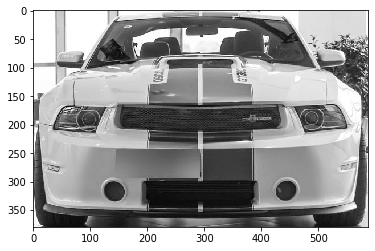

In [20]:
%matplotlib inline
import os
restore_image("nb_bins_6","(25,40,2),8,20,0.90")

In [19]:
hp1=[]
hp2=[]
hp3=[]
hp4=[]
for  i in range(80,100,2):
    hp1.append(calculer_hog(img_bound,512,512,8,i,i,1,1)[0])
    hp2.append(calculer_hog(img_bound,512,512,8,i,i,2,2)[0])
    hp3.append(calculer_hog(img_bound,512,512,8,i,i,3,3)[0])
    hp4.append(calculer_hog(img_bound,512,512,8,i,i,4,4)[0])

In [29]:
np.array(hp1).shape

(6, 244)

In [21]:
accuracy_1=[]
accuracy_2=[]
accuracy_3=[]
accuracy_4=[]
best_direction_acc1=[]
best_direction_acc2=[]
best_direction_acc3=[]
best_direction_acc4=[]
op_v1=[]
op_p1=[]
for i in range(len(hp1)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp1,accuracy_1),n_jobs=4,n_trials=100)
    op_v1.append(study.best_value)
    op_p1.append(study.best_params)
    best_direction_acc1.append(accuracy_1[study.best_trial.number])
op_v2=[]
op_p2=[]
for i in range(len(hp2)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp2,accuracy_2),n_jobs=4, n_trials=100)
    op_v2.append(study.best_value)
    op_p2.append(study.best_params)
    best_direction_acc2.append(accuracy_2[study.best_trial.number])
op_v3=[]
op_p3=[]
for i in range(len(hp3)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp3,accuracy_3),n_jobs=4, n_trials=100)
    op_v3.append(study.best_value)
    op_p3.append(study.best_params)
    best_direction_acc3.append(accuracy_3[study.best_trial.number])
op_v4=[]
op_p4=[]
for i in range(len(hp4)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp4,accuracy_4),n_jobs=4, n_trials=100)
    op_v4.append(study.best_value)
    op_p4.append(study.best_params)
    best_direction_acc4.append(accuracy_4[study.best_trial.number])

[I 2020-04-07 19:56:08,329] Finished trial#0 resulted in value: 0.6885245901639344. Current best value is 0.6885245901639344 with parameters: {'num_pca': 0.65, 'num_cluster': 8}.
[I 2020-04-07 19:56:08,910] Finished trial#2 resulted in value: 0.7377049180327869. Current best value is 0.7377049180327869 with parameters: {'num_pca': 0.62, 'num_cluster': 23}.
[I 2020-04-07 19:56:09,265] Finished trial#4 resulted in value: 0.5573770491803278. Current best value is 0.7377049180327869 with parameters: {'num_pca': 0.62, 'num_cluster': 23}.
[I 2020-04-07 19:56:09,766] Finished trial#3 resulted in value: 0.7704918032786885. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.77, 'num_cluster': 30}.
[I 2020-04-07 19:56:09,873] Finished trial#1 resulted in value: 0.7868852459016393. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.96, 'num_cluster': 26}.
[I 2020-04-07 19:56:10,070] Finished trial#6 resulted in value: 0.7213114754098361. Current best valu

[I 2020-04-07 19:56:46,713] Finished trial#92 resulted in value: 0.7049180327868853. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.6, 'num_cluster': 28}.
[I 2020-04-07 19:56:47,124] Finished trial#90 resulted in value: 0.7868852459016393. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.6, 'num_cluster': 28}.
[I 2020-04-07 19:56:47,599] Finished trial#93 resulted in value: 0.7868852459016393. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.6, 'num_cluster': 28}.
[I 2020-04-07 19:56:48,027] Finished trial#91 resulted in value: 0.7868852459016393. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.6, 'num_cluster': 28}.
[I 2020-04-07 19:56:48,498] Finished trial#94 resulted in value: 0.7704918032786885. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.6, 'num_cluster': 28}.
[I 2020-04-07 19:56:48,743] Finished trial#95 resulted in value: 0.7049180327868853. Current best va

[I 2020-04-07 19:57:20,273] Finished trial#81 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.56, 'num_cluster': 19}.
[I 2020-04-07 19:57:20,367] Finished trial#79 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.56, 'num_cluster': 19}.
[I 2020-04-07 19:57:20,531] Finished trial#82 resulted in value: 0.819672131147541. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.56, 'num_cluster': 19}.
[I 2020-04-07 19:57:21,422] Finished trial#83 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.56, 'num_cluster': 19}.
[I 2020-04-07 19:57:22,008] Finished trial#84 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.56, 'num_cluster': 19}.
[I 2020-04-07 19:57:22,581] Finished trial#85 resulted in value: 0.7704918032786885. Current bes

[I 2020-04-07 20:01:35,094] Finished trial#65 resulted in value: 0.7540983606557377. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:01:35,616] Finished trial#67 resulted in value: 0.7377049180327869. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:01:36,103] Finished trial#68 resulted in value: 0.8360655737704918. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:01:36,486] Finished trial#70 resulted in value: 0.7213114754098361. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:01:36,640] Finished trial#69 resulted in value: 0.7868852459016393. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:01:37,02

[I 2020-04-07 20:02:08,121] Finished trial#53 resulted in value: 0.819672131147541. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.53, 'num_cluster': 18}.
[I 2020-04-07 20:02:08,261] Finished trial#54 resulted in value: 0.819672131147541. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.53, 'num_cluster': 18}.
[I 2020-04-07 20:02:08,382] Finished trial#55 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.53, 'num_cluster': 18}.
[I 2020-04-07 20:02:09,068] Finished trial#58 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.53, 'num_cluster': 18}.
[I 2020-04-07 20:02:09,184] Finished trial#59 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.53, 'num_cluster': 18}.
[I 2020-04-07 20:02:09,366] Finished trial#56 resulted in value: 0.7377049180327869. Current best

[I 2020-04-07 20:02:37,286] Finished trial#42 resulted in value: 0.819672131147541. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:02:37,532] Finished trial#43 resulted in value: 0.819672131147541. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:02:37,923] Finished trial#44 resulted in value: 0.9016393442622951. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:02:38,311] Finished trial#45 resulted in value: 0.7868852459016393. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:02:38,662] Finished trial#47 resulted in value: 0.7868852459016393. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 24}.
[I 2020-04-07 20:02:38,781]

[I 2020-04-07 20:03:05,467] Finished trial#28 resulted in value: 0.8032786885245902. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.81, 'num_cluster': 24}.
[I 2020-04-07 20:03:05,593] Finished trial#29 resulted in value: 0.7377049180327869. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.81, 'num_cluster': 24}.
[I 2020-04-07 20:03:05,782] Finished trial#31 resulted in value: 0.7540983606557377. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.81, 'num_cluster': 24}.
[I 2020-04-07 20:03:05,945] Finished trial#30 resulted in value: 0.7540983606557377. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.81, 'num_cluster': 24}.
[I 2020-04-07 20:03:06,596] Finished trial#34 resulted in value: 0.7377049180327869. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.81, 'num_cluster': 24}.
[I 2020-04-07 20:03:06,735] Finished trial#32 resulted in value: 0.7377049180327869. Current be

[I 2020-04-07 20:03:34,602] Finished trial#18 resulted in value: 0.7704918032786885. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.97, 'num_cluster': 23}.
[I 2020-04-07 20:03:34,747] Finished trial#19 resulted in value: 0.7704918032786885. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.97, 'num_cluster': 23}.
[I 2020-04-07 20:03:35,189] Finished trial#20 resulted in value: 0.7704918032786885. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.97, 'num_cluster': 23}.
[I 2020-04-07 20:03:35,309] Finished trial#21 resulted in value: 0.7540983606557377. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.97, 'num_cluster': 23}.
[I 2020-04-07 20:03:35,738] Finished trial#22 resulted in value: 0.7049180327868853. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.97, 'num_cluster': 23}.
[I 2020-04-07 20:03:35,909] Finished trial#23 resulted in value: 0.6885245901639344. Current be

[I 2020-04-07 20:04:03,821] Finished trial#5 resulted in value: 0.7049180327868853. Current best value is 0.7213114754098361 with parameters: {'num_pca': 0.88, 'num_cluster': 29}.
[I 2020-04-07 20:04:03,901] Finished trial#1 resulted in value: 0.7868852459016393. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:04,112] Finished trial#4 resulted in value: 0.7377049180327869. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:04,539] Finished trial#8 resulted in value: 0.6229508196721312. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:04,829] Finished trial#6 resulted in value: 0.7049180327868853. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:05,000] Finished trial#7 resulted in value: 0.7868852459016393. Current best val

[I 2020-04-07 20:04:32,424] Finished trial#94 resulted in value: 0.7868852459016393. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:33,102] Finished trial#95 resulted in value: 0.6885245901639344. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:33,207] Finished trial#93 resulted in value: 0.6885245901639344. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:33,386] Finished trial#96 resulted in value: 0.7049180327868853. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:33,516] Finished trial#97 resulted in value: 0.7540983606557377. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 23}.
[I 2020-04-07 20:04:33,937] Finished trial#98 resulted in value: 0.7868852459016393. Current be

[I 2020-04-07 20:05:05,930] Finished trial#83 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.97, 'num_cluster': 28}.
[I 2020-04-07 20:05:05,930] Finished trial#84 resulted in value: 0.7049180327868853. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.97, 'num_cluster': 28}.
[I 2020-04-07 20:05:06,678] Finished trial#85 resulted in value: 0.6557377049180327. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.97, 'num_cluster': 28}.
[I 2020-04-07 20:05:06,897] Finished trial#86 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.97, 'num_cluster': 28}.
[I 2020-04-07 20:05:07,153] Finished trial#88 resulted in value: 0.6885245901639344. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.97, 'num_cluster': 28}.
[I 2020-04-07 20:05:07,373] Finished trial#87 resulted in value: 0.6885245901639344. Current best va

[I 2020-04-07 20:05:37,897] Finished trial#72 resulted in value: 0.7377049180327869. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.79, 'num_cluster': 28}.
[I 2020-04-07 20:05:38,538] Finished trial#73 resulted in value: 0.7377049180327869. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.79, 'num_cluster': 28}.
[I 2020-04-07 20:05:38,816] Finished trial#74 resulted in value: 0.7377049180327869. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.79, 'num_cluster': 28}.
[I 2020-04-07 20:05:39,345] Finished trial#75 resulted in value: 0.7213114754098361. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.79, 'num_cluster': 28}.
[I 2020-04-07 20:05:39,530] Finished trial#76 resulted in value: 0.7213114754098361. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.79, 'num_cluster': 28}.
[I 2020-04-07 20:05:40,205] Finished trial#78 resulted in value: 0.8032786885245902. Current best va

[I 2020-04-07 20:06:09,342] Finished trial#60 resulted in value: 0.7868852459016393. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.87, 'num_cluster': 29}.
[I 2020-04-07 20:06:09,833] Finished trial#62 resulted in value: 0.819672131147541. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.87, 'num_cluster': 29}.
[I 2020-04-07 20:06:10,401] Finished trial#63 resulted in value: 0.8360655737704918. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.87, 'num_cluster': 29}.
[I 2020-04-07 20:06:10,734] Finished trial#64 resulted in value: 0.8524590163934426. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.87, 'num_cluster': 29}.
[I 2020-04-07 20:06:11,029] Finished trial#65 resulted in value: 0.7540983606557377. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.87, 'num_cluster': 29}.
[I 2020-04-07 20:06:11,596] Finished trial#66 resulted in value: 0.7540983606557377. Current bes

[I 2020-04-07 20:06:42,542] Finished trial#50 resulted in value: 0.7213114754098361. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.7, 'num_cluster': 30}.
[I 2020-04-07 20:06:43,401] Finished trial#52 resulted in value: 0.7377049180327869. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.7, 'num_cluster': 30}.
[I 2020-04-07 20:06:44,007] Finished trial#53 resulted in value: 0.7704918032786885. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.7, 'num_cluster': 30}.
[I 2020-04-07 20:06:44,008] Finished trial#54 resulted in value: 0.7868852459016393. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.7, 'num_cluster': 30}.
[I 2020-04-07 20:06:44,519] Finished trial#55 resulted in value: 0.7868852459016393. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.7, 'num_cluster': 30}.
[I 2020-04-07 20:06:45,170] Finished trial#56 resulted in value: 0.8032786885245902. Current best va

[I 2020-04-07 20:07:19,941] Finished trial#41 resulted in value: 0.7540983606557377. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.79, 'num_cluster': 15}.
[I 2020-04-07 20:07:20,145] Finished trial#42 resulted in value: 0.7540983606557377. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.79, 'num_cluster': 15}.
[I 2020-04-07 20:07:20,253] Finished trial#43 resulted in value: 0.7704918032786885. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.79, 'num_cluster': 15}.
[I 2020-04-07 20:07:20,915] Finished trial#46 resulted in value: 0.5901639344262295. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.79, 'num_cluster': 15}.
[I 2020-04-07 20:07:21,185] Finished trial#44 resulted in value: 0.7704918032786885. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.79, 'num_cluster': 15}.
[I 2020-04-07 20:07:21,441] Finished trial#45 resulted in value: 0.7049180327868853. Current be

[I 2020-04-07 20:07:48,609] Finished trial#31 resulted in value: 0.7377049180327869. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.95, 'num_cluster': 15}.
[I 2020-04-07 20:07:48,921] Finished trial#32 resulted in value: 0.6065573770491803. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.95, 'num_cluster': 15}.
[I 2020-04-07 20:07:49,274] Finished trial#33 resulted in value: 0.6229508196721312. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.95, 'num_cluster': 15}.
[I 2020-04-07 20:07:49,723] Finished trial#34 resulted in value: 0.6229508196721312. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.95, 'num_cluster': 15}.
[I 2020-04-07 20:07:49,976] Finished trial#35 resulted in value: 0.6229508196721312. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.95, 'num_cluster': 15}.
[I 2020-04-07 20:07:50,782] Finished trial#39 resulted in value: 0.7213114754098361. Current be

[I 2020-04-07 20:08:14,799] Finished trial#21 resulted in value: 0.7213114754098361. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.96, 'num_cluster': 27}.
[I 2020-04-07 20:08:14,913] Finished trial#22 resulted in value: 0.7377049180327869. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.96, 'num_cluster': 27}.
[I 2020-04-07 20:08:15,062] Finished trial#23 resulted in value: 0.7540983606557377. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.96, 'num_cluster': 27}.
[I 2020-04-07 20:08:15,555] Finished trial#24 resulted in value: 0.7540983606557377. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.96, 'num_cluster': 27}.
[I 2020-04-07 20:08:15,770] Finished trial#25 resulted in value: 0.7704918032786885. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.96, 'num_cluster': 27}.
[I 2020-04-07 20:08:16,100] Finished trial#26 resulted in value: 0.819672131147541. Current bes

[I 2020-04-07 20:08:46,446] Finished trial#11 resulted in value: 0.819672131147541. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-04-07 20:08:46,598] Finished trial#13 resulted in value: 0.5573770491803278. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-04-07 20:08:46,758] Finished trial#12 resulted in value: 0.7868852459016393. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-04-07 20:08:47,325] Finished trial#14 resulted in value: 0.6885245901639344. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-04-07 20:08:47,557] Finished trial#15 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-04-07 20:08:47,643] Finished trial#16 resulted in value: 0.7868852459016393. Current best val

[I 2020-04-07 20:09:10,340] Finished trial#2 resulted in value: 0.7213114754098361. Current best value is 0.7213114754098361 with parameters: {'num_pca': 0.69, 'num_cluster': 13}.
[I 2020-04-07 20:09:10,478] Finished trial#1 resulted in value: 0.7704918032786885. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-04-07 20:09:10,895] Finished trial#3 resulted in value: 0.6885245901639344. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-04-07 20:09:11,064] Finished trial#4 resulted in value: 0.7213114754098361. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-04-07 20:09:11,420] Finished trial#6 resulted in value: 0.7213114754098361. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-04-07 20:09:11,693] Finished trial#7

[I 2020-04-07 20:09:41,161] Finished trial#91 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.87, 'num_cluster': 26}.
[I 2020-04-07 20:09:41,292] Finished trial#90 resulted in value: 0.7868852459016393. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.87, 'num_cluster': 26}.
[I 2020-04-07 20:09:41,859] Finished trial#92 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.87, 'num_cluster': 26}.
[I 2020-04-07 20:09:42,023] Finished trial#95 resulted in value: 0.7868852459016393. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.87, 'num_cluster': 26}.
[I 2020-04-07 20:09:42,342] Finished trial#93 resulted in value: 0.7377049180327869. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.87, 'num_cluster': 26}.
[I 2020-04-07 20:09:43,198] Finished trial#94 resulted in value: 0.7868852459016393. Current be

[I 2020-04-07 20:10:04,544] Finished trial#79 resulted in value: 0.7049180327868853. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 8}.
[I 2020-04-07 20:10:04,679] Finished trial#80 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 8}.
[I 2020-04-07 20:10:04,801] Finished trial#78 resulted in value: 0.7540983606557377. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 8}.
[I 2020-04-07 20:10:05,197] Finished trial#81 resulted in value: 0.7213114754098361. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 8}.
[I 2020-04-07 20:10:05,603] Finished trial#82 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 8}.
[I 2020-04-07 20:10:05,777] Finishe

[I 2020-04-07 20:10:31,798] Finished trial#67 resulted in value: 0.7868852459016393. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 29}.
[I 2020-04-07 20:10:32,100] Finished trial#69 resulted in value: 0.7540983606557377. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 29}.
[I 2020-04-07 20:10:32,297] Finished trial#68 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 29}.
[I 2020-04-07 20:10:32,693] Finished trial#70 resulted in value: 0.7540983606557377. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 29}.
[I 2020-04-07 20:10:33,060] Finished trial#71 resulted in value: 0.7377049180327869. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.74, 'num_cluster': 29}.
[I 2020-04-07 20:10:33,230] Finished trial#73 resulted in value: 0.7868852459016393. Current best va

[I 2020-04-07 20:11:02,827] Finished trial#56 resulted in value: 0.7868852459016393. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.88, 'num_cluster': 28}.
[I 2020-04-07 20:11:03,317] Finished trial#57 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.88, 'num_cluster': 28}.
[I 2020-04-07 20:11:03,487] Finished trial#58 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.88, 'num_cluster': 28}.
[I 2020-04-07 20:11:03,848] Finished trial#59 resulted in value: 0.8032786885245902. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.88, 'num_cluster': 28}.
[I 2020-04-07 20:11:04,290] Finished trial#60 resulted in value: 0.8360655737704918. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.88, 'num_cluster': 28}.
[I 2020-04-07 20:11:04,597] Finished trial#61 resulted in value: 0.8360655737704918. Current be

[I 2020-04-07 20:11:38,700] Finished trial#44 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 28}.
[I 2020-04-07 20:11:38,947] Finished trial#45 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 28}.
[I 2020-04-07 20:11:40,351] Finished trial#49 resulted in value: 0.6885245901639344. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 28}.
[I 2020-04-07 20:11:40,562] Finished trial#48 resulted in value: 0.6885245901639344. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 28}.
[I 2020-04-07 20:11:40,930] Finished trial#47 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 28}.
[I 2020-04-07 20:11:41,18

[I 2020-04-07 20:12:16,859] Finished trial#30 resulted in value: 0.7049180327868853. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.76, 'num_cluster': 30}.
[I 2020-04-07 20:12:17,354] Finished trial#31 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.76, 'num_cluster': 30}.
[I 2020-04-07 20:12:17,529] Finished trial#32 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.76, 'num_cluster': 30}.
[I 2020-04-07 20:12:17,765] Finished trial#34 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.76, 'num_cluster': 30}.
[I 2020-04-07 20:12:17,870] Finished trial#33 resulted in value: 0.8032786885245902. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.76, 'num_cluster': 30}.
[I 2020-04-07 20:12:18,827] Finished trial#36 resulted in value: 0.7704918032786885. Current be

[I 2020-04-07 20:12:52,164] Finished trial#17 resulted in value: 0.7213114754098361. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.78, 'num_cluster': 30}.
[I 2020-04-07 20:12:53,123] Finished trial#19 resulted in value: 0.7213114754098361. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.78, 'num_cluster': 30}.
[I 2020-04-07 20:12:53,371] Finished trial#20 resulted in value: 0.7049180327868853. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.78, 'num_cluster': 30}.
[I 2020-04-07 20:12:54,033] Finished trial#21 resulted in value: 0.7377049180327869. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.78, 'num_cluster': 30}.
[I 2020-04-07 20:12:54,510] Finished trial#22 resulted in value: 0.7049180327868853. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.78, 'num_cluster': 30}.
[I 2020-04-07 20:12:54,639] Finished trial#24 resulted in value: 0.8360655737704918. Current best va

[I 2020-04-07 20:13:26,266] Finished trial#0 resulted in value: 0.7213114754098361. Current best value is 0.7213114754098361 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 12}.
[I 2020-04-07 20:13:26,603] Finished trial#1 resulted in value: 0.6721311475409836. Current best value is 0.7213114754098361 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 12}.
[I 2020-04-07 20:13:27,065] Finished trial#6 resulted in value: 0.6885245901639344. Current best value is 0.7213114754098361 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 12}.
[I 2020-04-07 20:13:27,464] Finished trial#5 resulted in value: 0.7049180327868853. Current best value is 0.7213114754098361 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 12}.
[I 2020-04-07 20:13:27,466] Finished trial#4 resulted in value: 0.7540983606557377. Current best value is 0.7540983606557377 with parameters: {'num_pca': 0.86, 'num_cluster': 29}.
[I 2020-04-07 20:13:27,609] Finished trial#8

[I 2020-04-07 20:13:55,867] Finished trial#93 resulted in value: 0.7377049180327869. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.99, 'num_cluster': 28}.
[I 2020-04-07 20:13:56,167] Finished trial#94 resulted in value: 0.7377049180327869. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.99, 'num_cluster': 28}.
[I 2020-04-07 20:13:56,566] Finished trial#92 resulted in value: 0.7540983606557377. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.99, 'num_cluster': 28}.
[I 2020-04-07 20:13:56,724] Finished trial#95 resulted in value: 0.6885245901639344. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.99, 'num_cluster': 28}.
[I 2020-04-07 20:13:57,152] Finished trial#96 resulted in value: 0.7049180327868853. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.99, 'num_cluster': 28}.
[I 2020-04-07 20:13:57,449] Finished trial#97 resulted in value: 0.7049180327868853. Current be

[I 2020-04-07 20:14:27,371] Finished trial#81 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.77, 'num_cluster': 26}.
[I 2020-04-07 20:14:27,840] Finished trial#83 resulted in value: 0.6721311475409836. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.77, 'num_cluster': 26}.
[I 2020-04-07 20:14:28,166] Finished trial#84 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.77, 'num_cluster': 26}.
[I 2020-04-07 20:14:28,484] Finished trial#85 resulted in value: 0.7540983606557377. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.77, 'num_cluster': 26}.
[I 2020-04-07 20:14:28,748] Finished trial#86 resulted in value: 0.7213114754098361. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.77, 'num_cluster': 26}.
[I 2020-04-07 20:14:29,482] Finished trial#87 resulted in value: 0.639344262295082. Current best val

[I 2020-04-07 20:14:57,429] Finished trial#72 resulted in value: 0.8032786885245902. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 30}.
[I 2020-04-07 20:14:57,843] Finished trial#75 resulted in value: 0.7377049180327869. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 30}.
[I 2020-04-07 20:14:58,071] Finished trial#74 resulted in value: 0.7049180327868853. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 30}.
[I 2020-04-07 20:14:58,398] Finished trial#73 resulted in value: 0.7049180327868853. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 30}.
[I 2020-04-07 20:14:58,946] Finished trial#76 resulted in value: 0.7540983606557377. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 30}.
[I 2020-04-07 20:14:59,320] Finished trial#77 resulted in value: 0.7049180327868853. Current be

[I 2020-04-07 20:15:28,875] Finished trial#60 resulted in value: 0.6721311475409836. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 20}.
[I 2020-04-07 20:15:29,153] Finished trial#58 resulted in value: 0.6721311475409836. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 20}.
[I 2020-04-07 20:15:29,613] Finished trial#61 resulted in value: 0.6557377049180327. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 20}.
[I 2020-04-07 20:15:29,733] Finished trial#62 resulted in value: 0.6885245901639344. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 20}.
[I 2020-04-07 20:15:30,208] Finished trial#63 resulted in value: 0.7049180327868853. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.9199999999999999, 'num_cluster': 20}.
[I 2020-04-07 20:15:30,52

[I 2020-04-07 20:16:00,332] Finished trial#47 resulted in value: 0.6229508196721312. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.99, 'num_cluster': 30}.
[I 2020-04-07 20:16:00,465] Finished trial#46 resulted in value: 0.6885245901639344. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.99, 'num_cluster': 30}.
[I 2020-04-07 20:16:01,173] Finished trial#48 resulted in value: 0.6885245901639344. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.99, 'num_cluster': 30}.
[I 2020-04-07 20:16:01,374] Finished trial#50 resulted in value: 0.6885245901639344. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.99, 'num_cluster': 30}.
[I 2020-04-07 20:16:01,581] Finished trial#51 resulted in value: 0.7868852459016393. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.99, 'num_cluster': 30}.
[I 2020-04-07 20:16:01,691] Finished trial#49 resulted in value: 0.7377049180327869. Current be

[I 2020-04-07 20:16:33,792] Finished trial#35 resulted in value: 0.8032786885245902. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.88, 'num_cluster': 30}.
[I 2020-04-07 20:16:34,011] Finished trial#37 resulted in value: 0.7377049180327869. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.88, 'num_cluster': 30}.
[I 2020-04-07 20:16:34,210] Finished trial#36 resulted in value: 0.7049180327868853. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.88, 'num_cluster': 30}.
[I 2020-04-07 20:16:34,671] Finished trial#39 resulted in value: 0.7049180327868853. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.88, 'num_cluster': 30}.
[I 2020-04-07 20:16:34,822] Finished trial#38 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.88, 'num_cluster': 30}.
[I 2020-04-07 20:16:35,207] Finished trial#40 resulted in value: 0.7213114754098361. Current best va

[I 2020-04-07 20:17:04,612] Finished trial#28 resulted in value: 0.6721311475409836. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.6, 'num_cluster': 30}.
[I 2020-04-07 20:17:04,756] Finished trial#27 resulted in value: 0.7704918032786885. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.6, 'num_cluster': 30}.
[I 2020-04-07 20:17:04,845] Finished trial#25 resulted in value: 0.7704918032786885. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.6, 'num_cluster': 30}.
[I 2020-04-07 20:17:04,979] Finished trial#26 resulted in value: 0.7540983606557377. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.6, 'num_cluster': 30}.
[I 2020-04-07 20:17:05,780] Finished trial#31 resulted in value: 0.7213114754098361. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.6, 'num_cluster': 30}.
[I 2020-04-07 20:17:05,955] Finished trial#29 resulted in value: 0.7704918032786885. Current best va

[I 2020-04-07 20:17:35,006] Finished trial#16 resulted in value: 0.7868852459016393. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-04-07 20:17:35,145] Finished trial#15 resulted in value: 0.6721311475409836. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-04-07 20:17:35,283] Finished trial#18 resulted in value: 0.8032786885245902. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-04-07 20:17:35,361] Finished trial#17 resulted in value: 0.7540983606557377. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-04-07 20:17:36,145] Finished trial#22 resulted in value: 0.7213114754098361. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-04-07 20:17:36,288] Finished trial#20 resulted in value: 0.7213114754098361. Current be

[I 2020-04-07 20:18:12,725] Finished trial#5 resulted in value: 0.7704918032786885. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 26}.
[I 2020-04-07 20:18:12,891] Finished trial#7 resulted in value: 0.7377049180327869. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 26}.
[I 2020-04-07 20:18:13,043] Finished trial#6 resulted in value: 0.7213114754098361. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 26}.
[I 2020-04-07 20:18:13,191] Finished trial#8 resulted in value: 0.7377049180327869. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 26}.
[I 2020-04-07 20:18:14,235] Finished trial#11 resulted in value: 0.7049180327868853. Current best value is 0.7704918032786885 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 26}.
[I 2020-04-07 20:18:14,774] F

[I 2020-04-07 20:18:46,822] Finished trial#93 resulted in value: 0.7540983606557377. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.94, 'num_cluster': 29}.
[I 2020-04-07 20:18:46,959] Finished trial#95 resulted in value: 0.7540983606557377. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.94, 'num_cluster': 29}.
[I 2020-04-07 20:18:47,718] Finished trial#96 resulted in value: 0.7540983606557377. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.94, 'num_cluster': 29}.
[I 2020-04-07 20:18:48,232] Finished trial#99 resulted in value: 0.7049180327868853. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.94, 'num_cluster': 29}.
[I 2020-04-07 20:18:48,368] Finished trial#97 resulted in value: 0.7704918032786885. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.94, 'num_cluster': 29}.
[I 2020-04-07 20:18:48,495] Finished trial#98 resulted in value: 0.7377049180327869. Current be

[I 2020-04-07 20:19:16,277] Finished trial#78 resulted in value: 0.7377049180327869. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 13}.
[I 2020-04-07 20:19:16,897] Finished trial#81 resulted in value: 0.7704918032786885. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 13}.
[I 2020-04-07 20:19:17,304] Finished trial#83 resulted in value: 0.7540983606557377. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 13}.
[I 2020-04-07 20:19:17,595] Finished trial#80 resulted in value: 0.819672131147541. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 13}.
[I 2020-04-07 20:19:17,817] Finished trial#82 resulted in value: 0.7377049180327869. Current best value is 0.8360655737704918 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 13}.
[I 2020-04-07 20:19:18,199

[I 2020-04-07 20:19:43,783] Finished trial#67 resulted in value: 0.7704918032786885. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 12}.
[I 2020-04-07 20:19:44,035] Finished trial#66 resulted in value: 0.7377049180327869. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 12}.
[I 2020-04-07 20:19:44,414] Finished trial#69 resulted in value: 0.6065573770491803. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 12}.
[I 2020-04-07 20:19:44,715] Finished trial#70 resulted in value: 0.6229508196721312. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 12}.
[I 2020-04-07 20:19:45,073] Finished trial#71 resulted in value: 0.5737704918032787. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.86, 'num_cluster': 12}.
[I 2020-04-07 20:19:45,199] Finished trial#72 resulted in value: 0.6885245901639344. Current be

[I 2020-04-07 20:20:08,224] Finished trial#54 resulted in value: 0.7704918032786885. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-04-07 20:20:08,596] Finished trial#55 resulted in value: 0.7540983606557377. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-04-07 20:20:08,838] Finished trial#57 resulted in value: 0.7868852459016393. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-04-07 20:20:09,049] Finished trial#56 resulted in value: 0.7377049180327869. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-04-07 20:20:09,194] Finished trial#58 resulted in value: 0.8032786885245902. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-04-07 20:20:09,593] Finished trial#59 resulted in value: 0.6721311475409836. Current be

[I 2020-04-07 20:20:33,766] Finished trial#41 resulted in value: 0.6721311475409836. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.67, 'num_cluster': 28}.
[I 2020-04-07 20:20:33,912] Finished trial#44 resulted in value: 0.7377049180327869. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.67, 'num_cluster': 28}.
[I 2020-04-07 20:20:34,009] Finished trial#43 resulted in value: 0.7377049180327869. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.67, 'num_cluster': 28}.
[I 2020-04-07 20:20:34,592] Finished trial#48 resulted in value: 0.6885245901639344. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.67, 'num_cluster': 28}.
[I 2020-04-07 20:20:34,792] Finished trial#47 resulted in value: 0.7213114754098361. Current best value is 0.8032786885245902 with parameters: {'num_pca': 0.67, 'num_cluster': 28}.
[I 2020-04-07 20:20:35,052] Finished trial#45 resulted in value: 0.7868852459016393. Current be

[I 2020-04-07 20:21:04,687] Finished trial#31 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9, 'num_cluster': 27}.
[I 2020-04-07 20:21:04,808] Finished trial#30 resulted in value: 0.7540983606557377. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9, 'num_cluster': 27}.
[I 2020-04-07 20:21:05,997] Finished trial#32 resulted in value: 0.6885245901639344. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9, 'num_cluster': 27}.
[I 2020-04-07 20:21:06,287] Finished trial#34 resulted in value: 0.7868852459016393. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9, 'num_cluster': 27}.
[I 2020-04-07 20:21:06,288] Finished trial#35 resulted in value: 0.7704918032786885. Current best value is 0.819672131147541 with parameters: {'num_pca': 0.9, 'num_cluster': 27}.
[I 2020-04-07 20:21:06,411] Finished trial#33 resulted in value: 0.7213114754098361. Current best value i

[I 2020-04-07 20:21:36,942] Finished trial#20 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.97, 'num_cluster': 17}.
[I 2020-04-07 20:21:37,432] Finished trial#22 resulted in value: 0.8032786885245902. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.97, 'num_cluster': 17}.
[I 2020-04-07 20:21:37,725] Finished trial#21 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.97, 'num_cluster': 17}.
[I 2020-04-07 20:21:37,993] Finished trial#23 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.97, 'num_cluster': 17}.
[I 2020-04-07 20:21:38,450] Finished trial#24 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.97, 'num_cluster': 17}.
[I 2020-04-07 20:21:38,977] Finished trial#25 resulted in value: 0.6229508196721312. Current be

[I 2020-04-07 20:22:08,189] Finished trial#9 resulted in value: 0.7377049180327869. Current best value is 0.7868852459016393 with parameters: {'num_pca': 0.59, 'num_cluster': 27}.
[I 2020-04-07 20:22:08,660] Finished trial#11 resulted in value: 0.8524590163934426. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 19}.
[I 2020-04-07 20:22:08,988] Finished trial#12 resulted in value: 0.7213114754098361. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 19}.
[I 2020-04-07 20:22:09,511] Finished trial#13 resulted in value: 0.7704918032786885. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 19}.
[I 2020-04-07 20:22:09,764] Finished trial#15 resulted in value: 0.7540983606557377. Current best value is 0.8524590163934426 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 19}.
[I 2020-04-07 20:22:10,076] Finished tri

[I 2020-04-07 20:22:41,729] Finished trial#96 resulted in value: 0.7704918032786885. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.89, 'num_cluster': 25}.
[I 2020-04-07 20:22:42,617] Finished trial#97 resulted in value: 0.8688524590163934. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.89, 'num_cluster': 25}.
[I 2020-04-07 20:22:42,691] Finished trial#98 resulted in value: 0.7704918032786885. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.89, 'num_cluster': 25}.
[I 2020-04-07 20:22:42,807] Finished trial#99 resulted in value: 0.7213114754098361. Current best value is 0.9016393442622951 with parameters: {'num_pca': 0.89, 'num_cluster': 25}.
[I 2020-04-07 20:22:43,484] Finished trial#0 resulted in value: 0.639344262295082. Current best value is 0.639344262295082 with parameters: {'num_pca': 0.61, 'num_cluster': 9}.
[I 2020-04-07 20:22:43,912] Finished trial#2 resulted in value: 0.7868852459016393. Current best va

[I 2020-04-07 20:23:14,097] Finished trial#82 resulted in value: 0.7377049180327869. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.96, 'num_cluster': 19}.
[I 2020-04-07 20:23:14,695] Finished trial#84 resulted in value: 0.7540983606557377. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.96, 'num_cluster': 19}.
[I 2020-04-07 20:23:15,532] Finished trial#85 resulted in value: 0.819672131147541. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.96, 'num_cluster': 19}.
[I 2020-04-07 20:23:15,824] Finished trial#87 resulted in value: 0.819672131147541. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.96, 'num_cluster': 19}.
[I 2020-04-07 20:23:16,037] Finished trial#86 resulted in value: 0.819672131147541. Current best value is 0.8688524590163934 with parameters: {'num_pca': 0.96, 'num_cluster': 19}.
[I 2020-04-07 20:23:16,601] Finished trial#88 resulted in value: 0.819672131147541. Current best v

In [23]:
x_axe=np.arange(80,100,2)
restore_var("nb_bins_6",5)

In [46]:
load_var("nb_bins_6",4)

In [16]:
x_axe=np.arange(20,50,5)

<IPython.core.display.Javascript object>


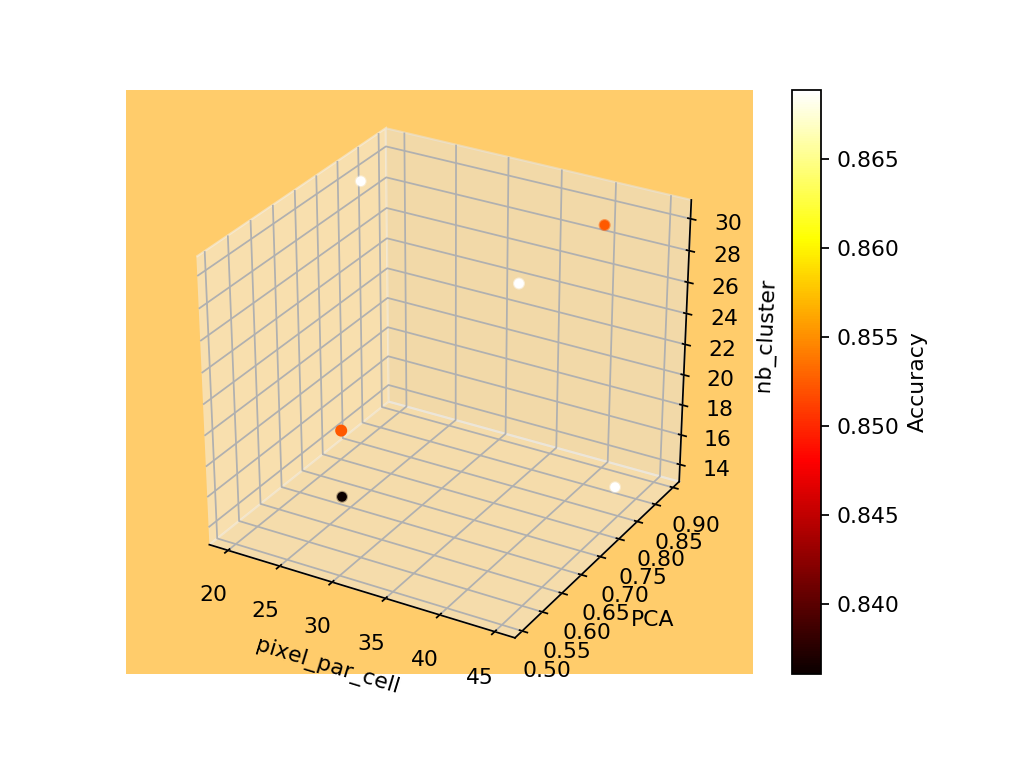

<IPython.core.display.Javascript object>


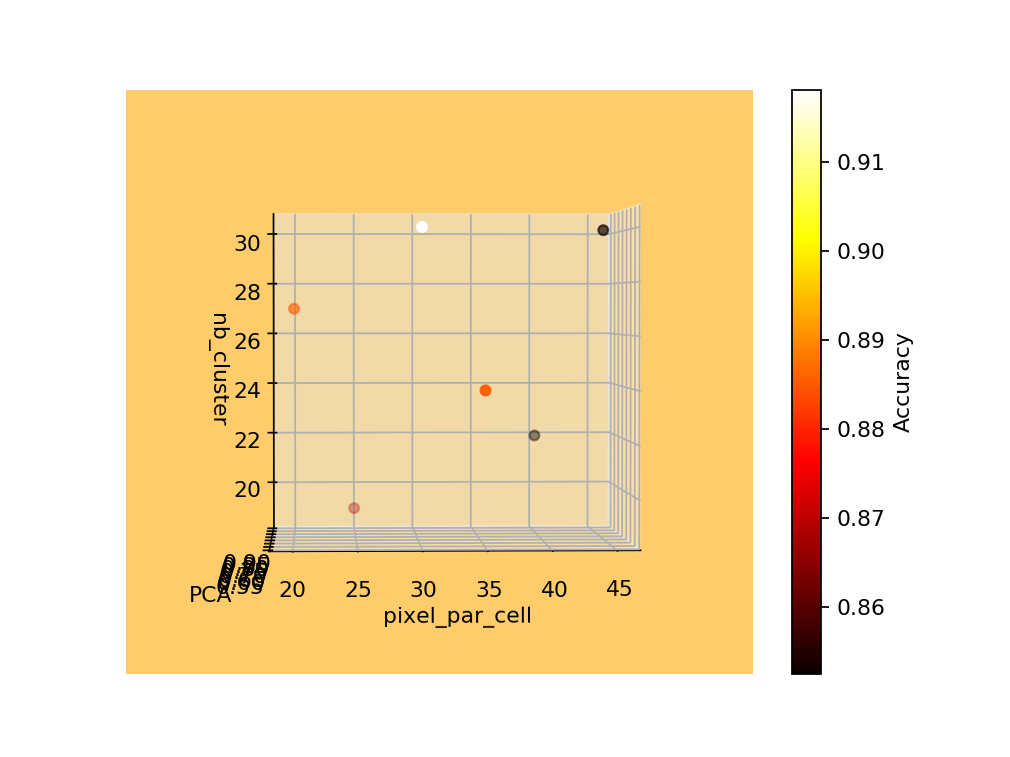

<IPython.core.display.Javascript object>


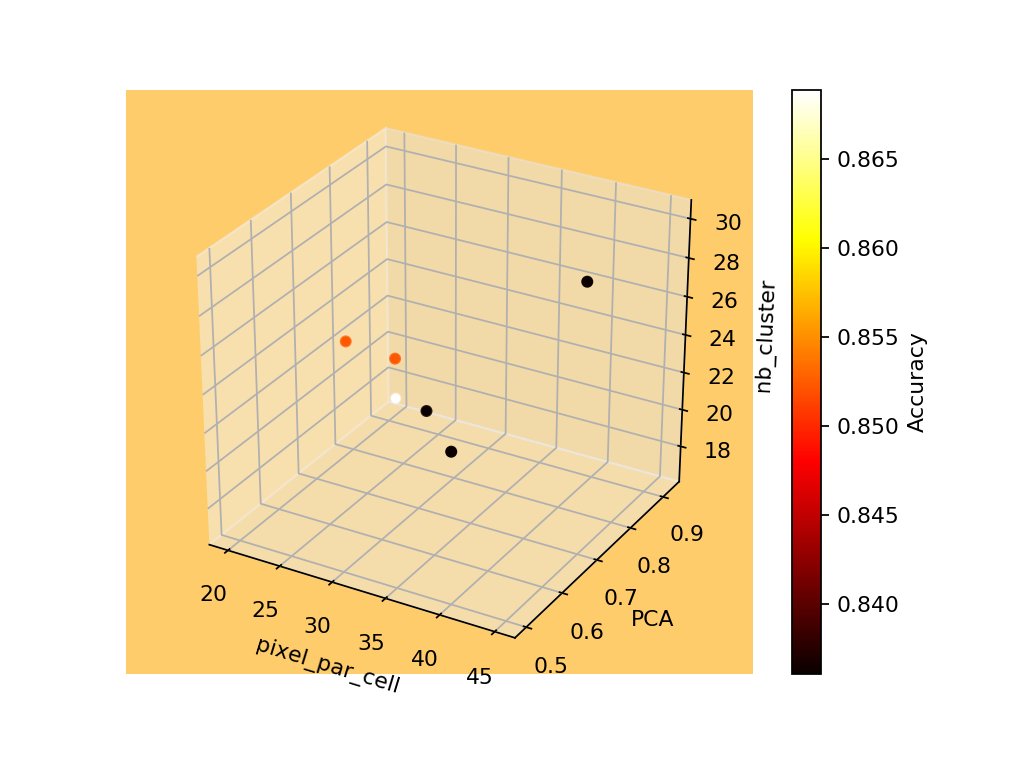

<IPython.core.display.Javascript object>


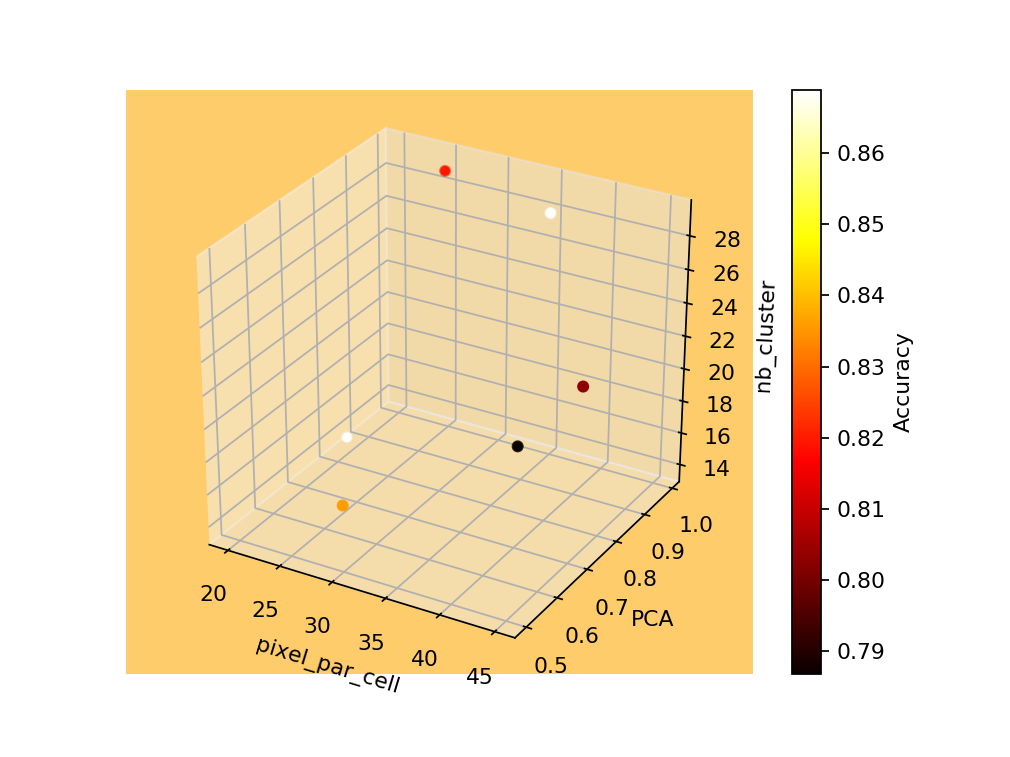

In [47]:
%matplotlib notebook
trace(x_axe)


In [15]:
best_direction_acc4[-2]

array([0.81818182, 0.63636364, 1.        , 0.84615385, 0.63636364])

In [18]:
op_p4

[{'num_pca': 0.99, 'num_cluster': 18},
 {'num_pca': 0.79, 'num_cluster': 26},
 {'num_pca': 0.77, 'num_cluster': 23},
 {'num_pca': 0.99, 'num_cluster': 22},
 {'num_pca': 0.97, 'num_cluster': 17},
 {'num_pca': 0.9199999999999999, 'num_cluster': 28},
 {'num_pca': 0.9, 'num_cluster': 20},
 {'num_pca': 0.96, 'num_cluster': 20}]

In [17]:
restore_var('nb_bins_6',"(25,40,2),8,20,0.90")

In [20]:
i,l=equilibrate_sample(10,1)

676
{4: 1, 5: 1, 2: 1, 1: 1, 3: 1}
1335
{4: 1, 5: 1, 3: 1, 1: 1}
1583
{3: 1, 5: 1, 4: 1, 1: 1, 2: 1}
1472
{4: 1, 5: 1, 2: 1, 1: 1, 3: 1}
674
{5: 1, 3: 1, 4: 1, 1: 1, 2: 1}
1011
{3: 1, 1: 1, 5: 1, 4: 1, 2: 1}
959
{4: 1, 1: 1, 5: 1, 3: 1, 2: 1}
103
{3: 1, 4: 1, 1: 1, 5: 1, 2: 1}
120
{4: 1, 3: 1, 2: 1, 5: 1, 1: 1}
740
{1: 1, 4: 1, 3: 1, 5: 1, 2: 1}


In [21]:
img_bound=Image_bound(img_table,label)
L=[]
for i in label.keys():
    L.append(label[i]["direction"])

In [23]:
h=calculer_hog(img_bound,512,512,8,30,30,2,2)[0]

In [39]:
load_var('nb_bins_6',4)

In [42]:
np.array(h).shape

(49, 8192)

In [43]:
np.array(hp2[2]).shape

(244, 8192)

In [45]:
def test_validation()
bound=vector_to_matrice(hp2[2])
p=PCA(n_components=0.56)
pca_bound=preprocessing.normalize(p.fit_transform(bound))
kmeans = KMeans(n_clusters=30, random_state=0)
clusters= kmeans.fit_predict(pca_bound)
mat = confusion_matrix(labels,clusters)
link={}
for i in range(mat.shape[0]):
    link[str(i)]=np.argmax(mat[:,i])
test=vector_to_matrice(h)
test=p.transform(test)
acc=np.zeros(5)
state=np.zeros(5)
for i in range(len(test)):
    state[L[i]-1]+=1
    if(link[str(cloest_centroid(test[i],kmeans.cluster_centers_))]==L[i]):
        acc[L[i]-1]+=1
score=acc.sum()/len(test)
score

0.7346938775510204